In [17]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [18]:
# 3계층의 신경망으로 MNIST 데이터를 학습하는 코드

import numpy as np
# 시그모이드 함수 expit() 사용을 위해 scipy.special 불러오기
from scipy.special import expit
# 행렬을 시각화하기 위한 라이브러리
import matplotlib.pyplot as plt
# 외부 윈도우가 아닌 현재에 노트북 내에서 시각화되도록 설정
activ_fct = lambda x: expit(x)
inverse_activ_fct = lambda x: np.log(x) - np.log(1 - x)
%matplotlib inline

In [3]:
# 신경망 클래스 정의
class neuralNetwork:

    # 신경망 초기화
    def __init__(self, inodes, h1nodes, h2nodes, onodes, lr):
        # 입력, 은닉, 출력 계층의 노드 개수 설정
        # NNlab1에서는 333, 222를 다뤘지만 각 계층의 노드 수가 다를 수도 있음
        self.inodes = inodes
        self.h1nodes = h1nodes
        self.h2nodes = h2nodes
        self.onodes = onodes

        # 가중치 행렬, 행렬은 대문자로 표기
        # 배열 내 가중치는 w_ij로 표기, 노드 i에서 다음 계층의 노드 j로 연결됨
        self.W_ih = np.random.normal(0.0, pow(self.h1nodes, -0.5), (self.h1nodes, self.inodes))
        self.W_h1h2 = np.random.normal(0.0, pow(self.h2nodes, -0.5), (self.h2nodes, self.h1nodes))
        self.W_ho = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.h2nodes))

        # 학습률
        self.lr = lr

        # 활성화 함수로는 시그모이드 함수를 이용
        self.activ_fct = lambda x: expit(x)
        self.inverse_activ_fct = lambda x: np.log(x) - np.log(1 - x)
        pass

    # 신경망 학습시키기
    def train(self, input_list, target_list):
        # 리스트(1 x n) -> 넘파이 행렬(n x 1)
        I_i = np.array(input_list, ndmin=2).T
        T_o = np.array(target_list, ndmin=2).T

        # 은닉 계층 1로 들어오는 신호
        I_h1 = np.dot(self.W_ih, I_i) # (주의)입력 계층에서는 I를 사용
        # 은닉 계층 1에서 나가는 신호
        O_h1 = self.activ_fct(I_h1)

        # 은닉 계층 2로 들어오는 신호
        I_h2 = np.dot(self.W_h1h2, O_h1) # 그 외 계층에서는 O를 사용
        # 은닉 계층 2에서 나가는 신호
        O_h2 = self.activ_fct(I_h2)

        # 출력 계층으로 들어오는 신호
        I_o = np.dot(self.W_ho, O_h2) # 그 외 계층에서는 O를 사용
        # 출력 계층에서 나가는 신호
        O_o = self.activ_fct(I_o)

        # 출력 계층의 오차는 (실제 값 - 계산 값)
        E_o = T_o - O_o
        # 은닉 계층 2의 오차는
        E_h2 = np.dot(self.W_ho.T, E_o)
        # 은닉 계층 1의 오차는
        E_h1 = np.dot(self.W_h1h2.T, E_h2)

        # 은닉 계층과 출력 계층 간의 가중치 업데이트 (W = W - lr * dE/dW, dE/dW = - (t - o) * ...)
        self.W_ho += self.lr * np.dot(E_o * O_o * (1.0 - O_o), O_h2.T)
        
        # 은닉 계층 1과 은닉계층 2 간의 가중치 업데이트
        self.W_h1h2 += self.lr * np.dot(E_h2 * O_h2 * (1.0 - O_h2), O_h1.T)

        # 입력 계층과 은닉 계층 간의 가중치 업데이트
        self.W_ih += self.lr * np.dot(E_h1 * O_h1 * (1 - O_h1), I_i.T)
        pass

    # 신경망에 질의하기
    def query(self, input_list):
        # 리스트(1 x n) -> 넘파이 행렬(n x 1)
        I_i = np.array(input_list, ndmin=2).T

        # 은닉 계층 1로 들어오는 신호
        I_h1 = np.dot(self.W_ih, I_i) # (주의)입력 계층에서는 I를 사용
        # 은닉 계층 1에서 나가는 신호
        O_h1 = self.activ_fct(I_h1)

        # 은닉 계층 2로 들어오는 신호
        I_h2 = np.dot(self.W_h1h2, O_h1) # 그 외 계층에서는 O를 사용
        # 은닉 계층 2에서 나가는 신호
        O_h2 = self.activ_fct(I_h2)

        # 출력 계층으로 들어오는 신호
        I_o = np.dot(self.W_ho, O_h2) # 그 외 계층에서는 O를 사용
        # 출력 계층에서 나가는 신호
        O_o = self.activ_fct(I_o)

        return O_o
    
    def backquery(self, target_list):
        # transpose the target list to a vertical array
        final_outputs = np.array(target_list, ndmin=2).T

        # calculate the signal into the final output layer
        final_inputs = self.inverse_activ_fct(final_outputs)

        # calculate the signal out of the hidden layer
        final_outputs = np.dot(self.W_ho.T, final_inputs)
        # scale them back from 0.01 to 0.99
        hidden_outputs -= np.min(hidden_outputs)
        hidden_outputs /= np.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01

        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activ_fct(hidden_outputs)

        # calculate the signal out of the input layer
        inputs = np.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to 0.99
        inputs -= np.min(inputs)
        inputs /= np.max(inputs)
        inputs *= 0.98
        inputs += 0.01

        return inputs

In [4]:
# 입력, 은닉, 출력 노드의 수
inodes = 784
h1nodes = 100
h2nodes = 100
onodes = 10

# 학습률
lr = 0.1

# 신경망의 인스턴스 생성
n = neuralNetwork(inodes, h1nodes, h2nodes, onodes, lr)

In [5]:
# mnist 학습 데이터 불러오기
train_data_file = open("../mnist_dataset/mnist_train.csv", "r")
train_data_list = train_data_file.readlines()
train_data_file.close()

len(train_data_list)

60000

In [ ]:
# 신경망 학습시키기

# 주기(epoch)란 학습 데이터가 학습을 위해 사용되는 횟수를 의미
epochs = 3

for i in range(epochs):
    print(f"epoch {i}", end=" ")
    # 학습 데이터의 레코드를 순서대로 방문
    for record in train_data_list:
        # 레코드를 쉼표로 split
        all_values = record.split(',')
        
        # 입력 값의 범위와 값 조정
        inputs = np.asfarray(all_values[1:]) / 255.0 * 0.99 + 0.01
        from scipy import ndimage
        # 오른쪽 10도
        inputs_plus10_img = ndimage.interpolation.rotate(inputs.reshape(28, 28), 10, cval=0.01, reshape=False)
        inputs_plus10 = inputs_plus10_img.reshape(784)
        # 왼쪽 10도
        inputs_minus10_img = ndimage.interpolation.rotate(inputs.reshape(28, 28), -10, cval=0.01, reshape=False)
        inputs_minus10 = inputs_minus10_img.reshape(784)
        
        # 결과 값 생성 (실제 값인 0.99 외에는 모두 0.01)
        targets = np.zeros(onodes) + 0.1
        targets[int(all_values[0])] = 0.99
        
        # 학습
        n.train(inputs, targets)
        n.train(inputs_plus10, targets)
        n.train(inputs_minus10, targets)
        pass
    print("done")
pass

In [16]:
import imageio
import glob# 입력, 은닉, 출력 노드의 수

('***correct_label', 0)

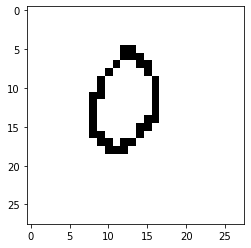

(28, 28)

Array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,
          0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [25

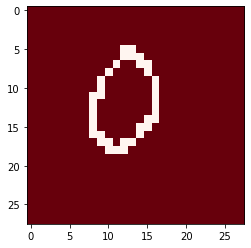

('***correct_label', 1)

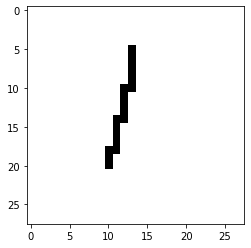

(28, 28)

Array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
          0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [25

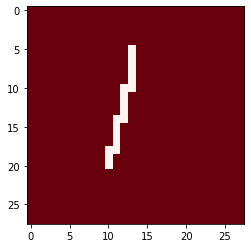

('***correct_label', 2)

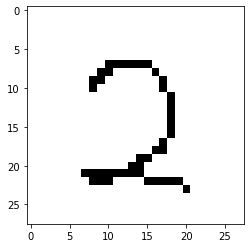

(28, 28)

Array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [25

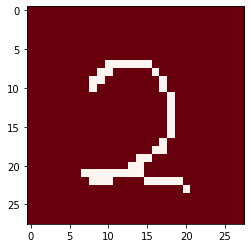

('***correct_label', 3)

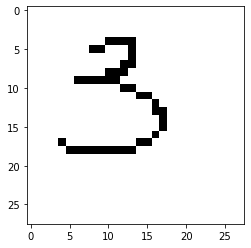

(28, 28)

Array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0,   0,
          0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255,   0,   0, 255, 255, 255,
          0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [25

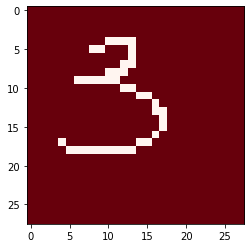

('***correct_label', 4)

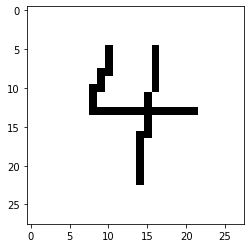

(28, 28)

Array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0, 255, 255,
        255, 255, 255,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [25

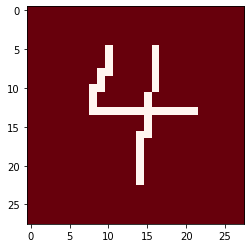

('***correct_label', 5)

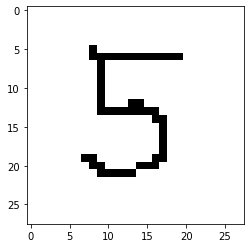

(28, 28)

Array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [25

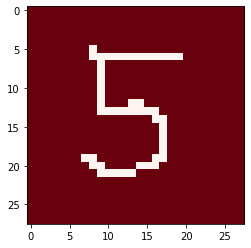

('***correct_label', 6)

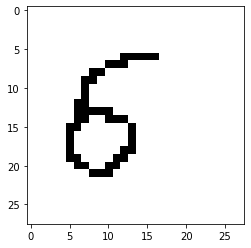

(28, 28)

Array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [25

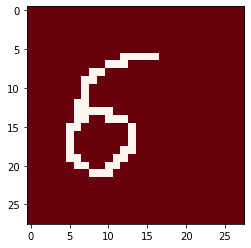

('***correct_label', 7)

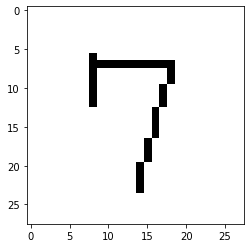

(28, 28)

Array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [25

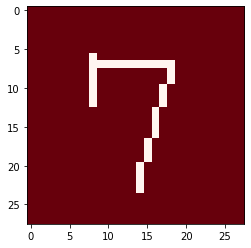

('***correct_label', 8)

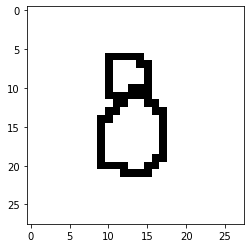

(28, 28)

Array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [25

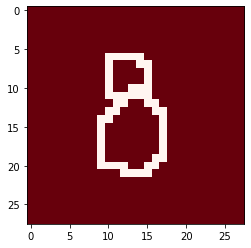

('***correct_label', 9)

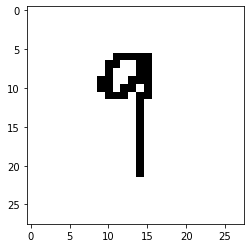

(28, 28)

Array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [25

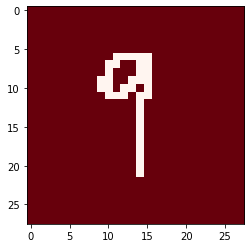

In [15]:
for image_file_name in glob.glob('img/?.png'):
    correct_label = int(image_file_name[-5])
    "***correct_label", correct_label
    
    image_array = imageio.imread(image_file_name)
    
    plt.imshow(image_array, cmap="Reds", interpolation="None")
    plt.show()
    
    image_array = image_array[:,:,0] # 컬러를 그레이 스케일로 변환
    image_array.shape
    image_array
    
    image_data = 255.0 - image_array.reshape(784) # 28x28 행렬 값을 784개 값의 리스트로 구성
    image_data = (image_data / 255.0 * 0.99) * 0.01 # 색상 값 반전
    
    plt.imshow(image_array, cmap="Reds", interpolation="None")
    plt.show()

('***correct_label', 0)

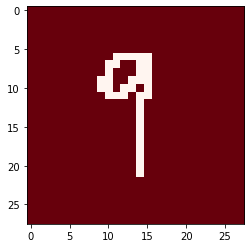

Array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

('***correct_label', 1)

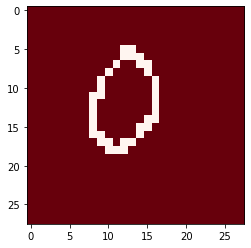

Array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

('***correct_label', 2)

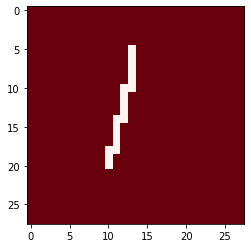

Array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

('***correct_label', 3)

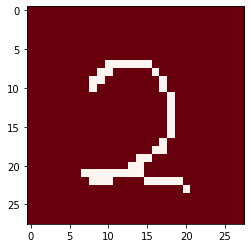

Array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

('***correct_label', 4)

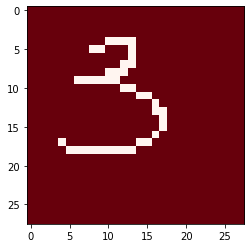

Array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

('***correct_label', 5)

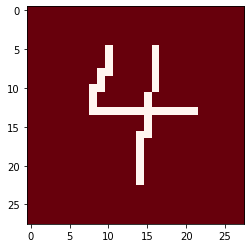

Array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

('***correct_label', 6)

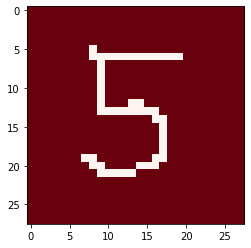

Array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

('***correct_label', 7)

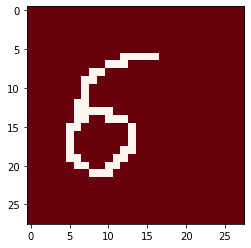

Array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

('***correct_label', 8)

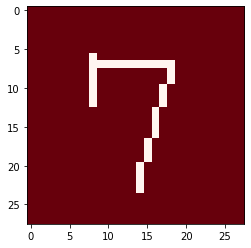

Array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

('***correct_label', 9)

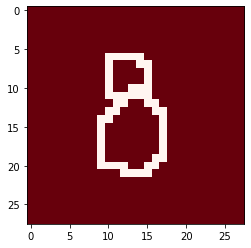

Array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

In [23]:
# 신경망 테스트

# 신경망 성능의 지표가 되는 성적표를 아무 값도 가지지 않도록 초기화
scorecard = []

for image_file_name in glob.glob('img/?.png'):
    correct_label = int(image_file_name[-5])
    "***correct_label", correct_label
    
    plt.imshow(image_array, cmap="Reds", interpolation="None")
    plt.show()
    
    image_array = imageio.imread(image_file_name)
    
    image_array = image_array[:,:,0] # 컬러를 그레이 스케일로 변환
    image_data = 255.0 - image_array.reshape(784) # 28x28 행렬 값을 784개 값의 리스트로 구성
    inputs = (image_data / 255.0 * 0.99) * 0.01 # 색상 값 반전
    # 신경망에 질의
    outputs = n.query(inputs)
    # 가장 높은 값의 인덱스는 레이블의 인덱스와 일치
    label = np.argmax(outputs)
    # 정답 또는 오답을 리스트에 추가
    if (label == correct_label): # 정답이면
        scorecard.append(1) # 성적표에 1을 추가
    else: # 오답이면
        scorecard.append(0) # 성적표에 0을 추가
        pass
    pass
    

In [9]:
# 정답의 비율인 성적을 계산해 출력
scorecard_array = np.asfarray(scorecard)
print(f"epochs = {epochs} h1nodes = {h1nodes} h2nodes = {h2nodes} lr = {lr} performance = {scorecard_array.sum() / scorecard_array.size}")

epochs = 5 h1nodes = 576 h2nodes = 400 lr = 0.1 performance = 0.9615
201400285 Sang Soon Lee


In [ ]:
# backquery
# label to test
for label in range(10):
    "label", label

    # create the output signals for this label
    targets = np.zeros(onodes) + 0.01
    # all_values[0] is the target label for this record
    targets[label] = 0.99
    targets
    
    # get image data
    image_data = n.backquery(targets)
    
    # plot image data
    plt.imshow(image_data.reshape(28, 28), cmap="Greys", interpolation="None")
    plt.show()
    pass